# Select Your Stock

In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
stock_name = 'META' # ticker symbol
df = pd.read_csv('./dataset/' + stock_name + '.csv')

# Preprocess 

In [3]:
from sklearn.preprocessing import MinMaxScaler
def retrieve_closing_prices_only(data):
    data = data[['Close']]
    return data

def min_max_scaling(data):
    scaler = MinMaxScaler(feature_range = (0, 1))
    data = scaler.fit_transform(data.values)
    return scaler, data
    
scaler, new_df = min_max_scaling(retrieve_closing_prices_only(df))

# Train Test Split

In [4]:
import numpy as np 
def split_and_reshape_data(dataframe, pred_days, company):
    prediction_days = pred_days
    
    train_size = int(np.ceil(len(dataframe) * 0.95))
    test_size = len(dataframe) - train_size
    print(f'The training size for {company.title()} is {train_size} rows')
    print(f'The testing size for {company.title()} is {test_size} rows')
    
    train_data = dataframe[0: int(train_size), :]
    test_data = dataframe[train_size - prediction_days:, :]
    
    X_train, y_train, X_test, y_test = [], [], [], []
    
    for i in range(prediction_days, len(train_data)):
        X_train.append(train_data[i - prediction_days: i, 0])
        y_train.append(train_data[i, 0])
        
    for i in range(prediction_days, len(test_data)):
        X_test.append(test_data[i - prediction_days: i, 0])
        y_test.append(test_data[i, 0])
        
    X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
        
    print('Data for {} split successfully'.format(company.title()))
    
    return X_train, y_train, X_test, y_test
    
X_train, y_train, X_test, y_test = split_and_reshape_data(new_df, 30, stock_name)

The training size for Meta is 2570 rows
The testing size for Meta is 135 rows
Data for Meta split successfully


# Train LSTM

In [5]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber


2023-02-18 18:11:15.157779: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-18 18:11:15.157820: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
def create_and_train_bilstm_model(X_train, y_train, X_test, y_test, company):
    
    print('=========For {}========='.format(company))
    
    model = Sequential([
    Conv1D(32, 3, strides = 1, activation = 'relu', input_shape = [30, 1]),
    Bidirectional(LSTM(64, return_sequences = True)),
    Bidirectional(LSTM(64, return_sequences = True)),
    Bidirectional(LSTM(64)),
    Dense(32, activation = 'relu'),
    Dense(1)
    ])
    
    model.compile(optimizer = Adam(), loss = Huber(), metrics = ['mse', 'mae'])
    
    predictor = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50)
    
    y_pred = model.predict(X_test)
    
    return model, predictor, y_pred

In [7]:
model, predictor, y_pred = create_and_train_bilstm_model(X_train, y_train, X_test, y_test, stock_name)

=========For META=========


2023-02-18 18:11:18.157383: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-18 18:11:18.157418: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-18 18:11:18.157438: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Tasus): /proc/driver/nvidia/version does not exist
2023-02-18 18:11:18.157723: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
80/80 [==============================] - 11s 48ms/step - loss: 0.0053 - mse: 0.0106 - mae: 0.0544 - val_loss: 0.0014 - val_mse: 0.0027 - val_mae: 0.0405
Epoch 2/50
80/80 [==============================] - 2s 31ms/step - loss: 6.0271e-04 - mse: 0.0012 - mae: 0.0219 - val_loss: 0.0011 - val_mse: 0.0023 - val_mae: 0.0361
Epoch 3/50
80/80 [==============================] - 3s 31ms/step - loss: 4.7175e-04 - mse: 9.4350e-04 - mae: 0.0194 - val_loss: 0.0011 - val_mse: 0.0022 - val_mae: 0.0357
Epoch 4/50
80/80 [==============================] - 3s 31ms/step - loss: 4.1026e-04 - mse: 8.2051e-04 - mae: 0.0183 - val_loss: 9.7051e-04 - val_mse: 0.0019 - val_mae: 0.0330
Epoch 5/50
80/80 [==============================] - 2s 31ms/step - loss: 3.6596e-04 - mse: 7.3191e-04 - mae: 0.0175 - val_loss: 7.3063e-04 - val_mse: 0.0015 - val_mae: 0.0278
Epoch 6/50
80/80 [==============================] - 3s 32ms/step - loss: 3.2608e-04 - mse: 6.5216e-04 - mae: 0.0165 - val_loss: 5.8806e-04 - val_mse

# Visualizations

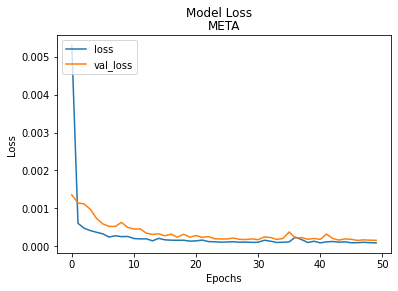

In [8]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
    
plt.suptitle('Model Loss')
axes.plot(predictor.epoch, predictor.history['loss'], label = 'loss')
axes.plot(predictor.epoch, predictor.history['val_loss'], label = 'val_loss')
axes.set_title(stock_name)
axes.set_xlabel('Epochs')
axes.set_ylabel('Loss')
axes.xaxis.set_tick_params()
axes.yaxis.set_tick_params()
axes.legend(loc = 'upper left')
    

In [9]:
def predictions_inverse_scaler_rmse(company, scaler, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
    
    print(f'The RMSE for {company} is {rmse}')
    
    return y_pred, y_test

In [10]:
y_pred, y_test = predictions_inverse_scaler_rmse(stock_name, scaler, model, X_test, y_test)

The RMSE for META is 6.415017999257095


In [11]:
def create_dataframes_for_plots(dataframe, y_pred):
    plot_train = dataframe[:int(np.ceil(len(dataframe) * 0.95))]
    plot_test = dataframe[int(np.ceil(len(dataframe) * 0.95)):]
    plot_test['Predictions'] = y_pred
    return plot_train, plot_test

plot_train, plot_test = create_dataframes_for_plots(df, y_pred)

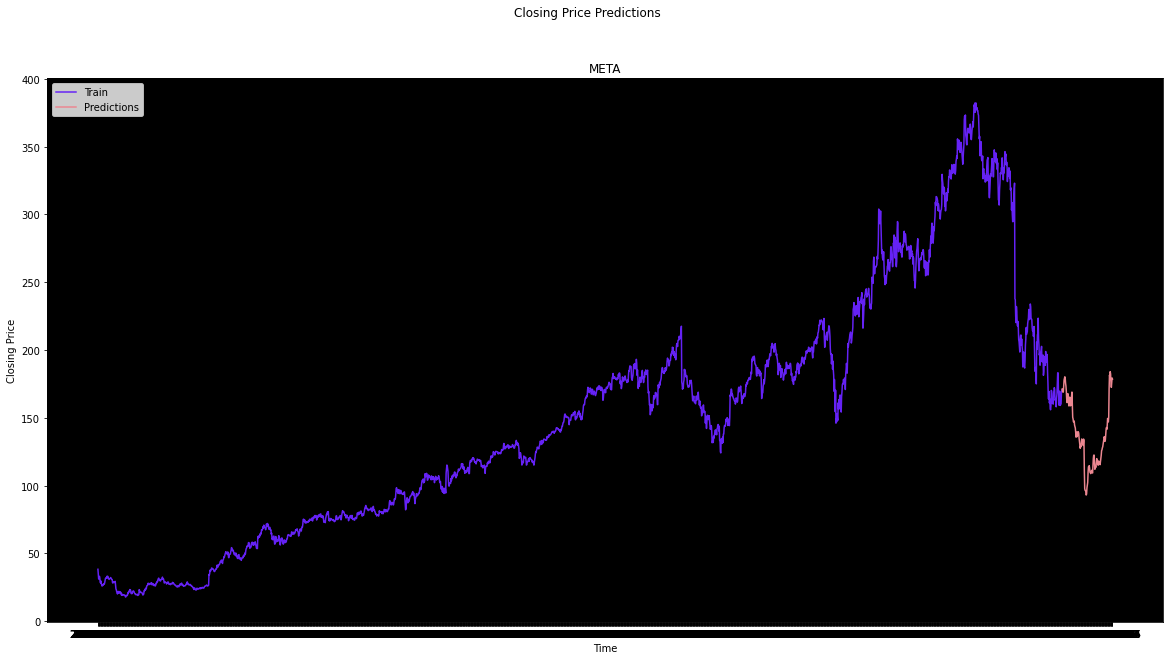

In [12]:
fig, axes = plt.subplots(figsize = (20, 10))
    
plt.suptitle('Closing Price Predictions')

axes.set_facecolor('black')
axes.plot(plot_train['Date'], plot_train['Close'], color = '#6522F5', label = 'Train')
axes.plot(plot_test['Date'], plot_test['Predictions'], color = '#EB8791', label = 'Predictions')
axes.set_title(stock_name)
axes.set_xlabel('Time')
axes.set_ylabel('Closing Price')
axes.xaxis.set_tick_params()
axes.yaxis.set_tick_params()
axes.legend(loc = 'upper left')
plt.show()
    